[View in Colaboratory](https://colab.research.google.com/github/redpanda-ai/epi_python/blob/master/taxi_v2_Monte_Carlo_GLIE.ipynb)

In [1]:
!pip --no-cache-dir install seaborn==0.9.0 gym==0.10.8 pandas==0.23.4 

    100% |████████████████████████████████| 215kB 5.0MB/s 
    100% |████████████████████████████████| 1.5MB 11.3MB/s 
    100% |████████████████████████████████| 8.9MB 1.4MB/s 
    100% |████████████████████████████████| 1.0MB 59.4MB/s 
  Found existing installation: pandas 0.22.0
    Uninstalling pandas-0.22.0:
      Successfully uninstalled pandas-0.22.0
  Found existing installation: seaborn 0.7.1
    Uninstalling seaborn-0.7.1:
      Successfully uninstalled seaborn-0.7.1
  Running setup.py install for gym ... - \ | done


In [0]:
import gym
import numpy as np
import pandas as pd
import time

from gym import wrappers

# Helper Functions
def update_report(report):
    """Calculates training metrics and stores them in a pandas dataframe"""
    r = report
    r['last_avg_total_score'] = r['avg_total_score']
    r['avg_total_score'] = sum(r['rewards_list']) / (r['episode_interval'])
    
    # calculate delta
    delta = r['avg_total_score'] - r['last_avg_total_score']
    
    print(f"K episodes: {r['k_episodes']:>8.3f} "
          f"Average Total Score: {r['avg_total_score']:>10.3f} "
          f"Delta: {delta:>10.3f} "
          f"Epsilon: {r['epsilon']:>10.3f} ")
    
    # add to dataframe
    r['df'].loc[r['df_index']] = [r['k_episodes'], r['avg_total_score'], delta,
                                  r['epsilon']]
    r['df_index'] += 1
    
    # re-initialize rewards_list - allows us to only capture last 
    # episode_interval runs
    r['rewards_list'] = []


def get_epsilon(target_epsilon, i, episode_interval, num_episodes):
    """Creates a function that changes the value of epsilon over time"""
    if i > num_episodes * 0.95:
        return 0.0
    else:
        return 0.3 * (1 - (i / num_episodes)) + target_epsilon


# Main
def main(num_episodes=10000, target_epsilon=0.2, episode_interval=1000):
    start_time = time.time()
    
    # create our environment
    env = gym.make("Taxi-v2")
    env = wrappers.Monitor(env, "./results", force=True)

    # initialize the action value function Q(s, a), 
    # and a counter function N(s, a)
          
    # log_df = pd.DataFrame(columns=['episode_number', 'line_number', 'new_state', 'reward', 'done', 'episode_length'])  
    # log_id = 0
    Q = np.zeros([env.observation_space.n, env.action_space.n])
    Q_old = Q.copy()
    n_s_a = np.zeros([env.observation_space.n, env.action_space.n])

    labels = ['k episodes', 'Average Total Score', 'Delta', 'Epsilon']
    report = {
        'rewards_list' : [],
        'avg_total_score' : 0,
        'last_avg_total_score' : 0,
        'df': pd.DataFrame(columns=labels),
        'df_index': 0,
        'episode_interval': episode_interval,
    }
    
    # set df labels type
    report['df'][labels] = report['df'][labels].astype(float)
    
    # line_number = 0
    # last_line_number = 0
    for i in range(num_episodes + 1):

        state = env.reset()
        r_all = 0 # sum of all rewards
        done = False
        results_list = []
        results_sum = 0.0
        
        while not done:
            if np.random.rand() < target_epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state, :])
            new_state, reward, done, _ = env.step(action)
          
            # if done:
            #     if reward == 20:
            #         episode_length = line_number - last_line_number
            #         log_df.loc[log_id] = [log_id, line_number, new_state, reward, done, episode_length]
            #    log_id += 1
            #    last_line_number = line_number
          
            results_list.append((state, action))
            results_sum += reward
            state = new_state
            r_all += reward
            # line_number += 1
        
        report['rewards_list'].append(r_all)

        for (state, action) in results_list:
            n_s_a[state, action] += 1.0
            alpha = 1.0 / n_s_a[state, action]
            Q[state, action] += alpha * (results_sum - Q[state, action])

        
        if i % report['episode_interval'] == 0 and i is not 0:
            report['k_episodes'] = i / 1000.0
            report['epsilon'] = get_epsilon(target_epsilon, i,
                                            report['episode_interval'],
                                            num_episodes)
            
            # update report
            update_report(report)

    env.close()
    
    end_time = time.time()
    run_time = end_time - start_time
    print(f"Time taken: {end_time - start_time:10.2f} seconds")
    return (report['df'], run_time, Q, Q_old)


In [3]:
#@title Set the Training Parameters

number_episodes = 20000 #@param {type:"slider", min:1000, max:1000000, step:1000}
target_epsilon = 0.2 #@param {type:"slider", min:0.0, max:1.0, step:0.01}
episode_interval = 1000 #@param {type:"slider", min:500, max:10000}

def print_params():
  print(f"Training Parameters set to:"
        f"\n\tNumber of Episodes : {number_episodes:>8}"
        f"\n\tTarget Epsilon     : {target_epsilon:>8.2f}"
        f"\n\tEpisode Interval   : {episode_interval:>8}")
  
print_params()

Training Parameters set to:
	Number of Episodes :    20000
	Target Epsilon     :     0.20
	Episode Interval   :     1000


In [4]:
"""Train Q"""
print_params()
df, run_time, Q, Q_old = main(num_episodes=number_episodes,
                    target_epsilon=target_epsilon,
                    episode_interval=episode_interval)
print(f"Data Frame Size: {df.shape}")


Training Parameters set to:
	Number of Episodes :    20000
	Target Epsilon     :     0.20
	Episode Interval   :     1000
K episodes:    1.000 Average Total Score:   -446.484 Delta:   -446.484 Epsilon:      0.485 
K episodes:    2.000 Average Total Score:   -337.894 Delta:    108.590 Epsilon:      0.470 
K episodes:    3.000 Average Total Score:   -320.881 Delta:     17.013 Epsilon:      0.455 
K episodes:    4.000 Average Total Score:   -318.495 Delta:      2.386 Epsilon:      0.440 
K episodes:    5.000 Average Total Score:   -316.209 Delta:      2.286 Epsilon:      0.425 
K episodes:    6.000 Average Total Score:   -313.721 Delta:      2.488 Epsilon:      0.410 
K episodes:    7.000 Average Total Score:   -312.361 Delta:      1.360 Epsilon:      0.395 
K episodes:    8.000 Average Total Score:   -298.919 Delta:     13.442 Epsilon:      0.380 
K episodes:    9.000 Average Total Score:   -290.910 Delta:      8.009 Epsilon:      0.365 
K episodes:   10.000 Average Total Score:   -276.71

In [0]:
"""Import some plotting libraries"""
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

def plot_helper(x="k episodes", y="k episodes", palette="Blues", orient="v"):
  """This just helps me draw simple bar charts for my pandas dataframe"""
  a4_dims=(11.7, 8.27)
  my_df = df[[x, y]]
  sns.set(style="darkgrid")
  fig, ax = plt.subplots(figsize=a4_dims)
  sns.barplot(ax=ax, data=my_df, x=x, y=y,
             palette=palette, orient=orient)
  _ = ax.set(xlabel=x, ylabel=y,
           title=f"{x} vs {y}")


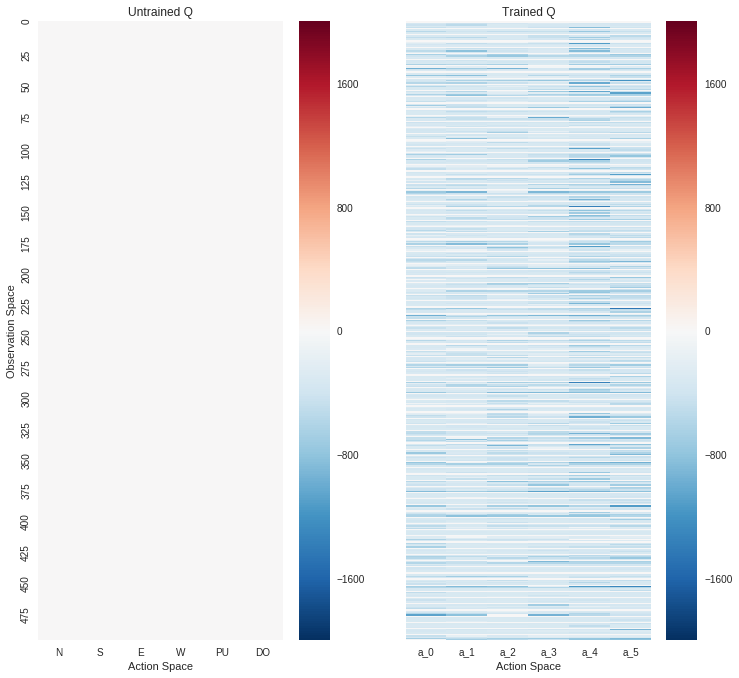

In [6]:
#in the untrained Q function, everything is set to 0
q_old_df = pd.DataFrame(data=Q_old,
                        columns=["N", "S", "E", "W", "PU", "DO"])

# however the new Q function has values indicating that some actions are better
# given a particular state
q_df = pd.DataFrame(data=Q, columns=[f"a_{i}" for i in range(Q.shape[1])])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10.7, 12.27), sharey=True)

plt.subplots_adjust(bottom=0.2, right=1.0, top=0.9)

_ = sns.heatmap(ax=ax1, data=q_old_df, center=0, yticklabels=25,
                vmax=0, vmin=-2000)
_ = sns.heatmap(ax=ax2, data=q_df, center=0, yticklabels=25,
                vmax=0, vmin=-2000)
_ = ax1.set(xlabel="Action Space", ylabel="Observation Space", title="Untrained Q")
_ = ax2.set(xlabel="Action Space", title="Trained Q")

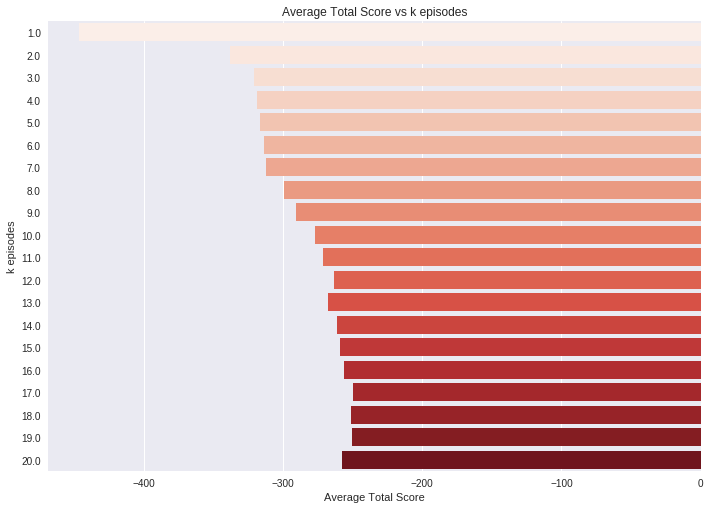

In [7]:
_ = plot_helper(x="Average Total Score", palette="Reds", orient="h")

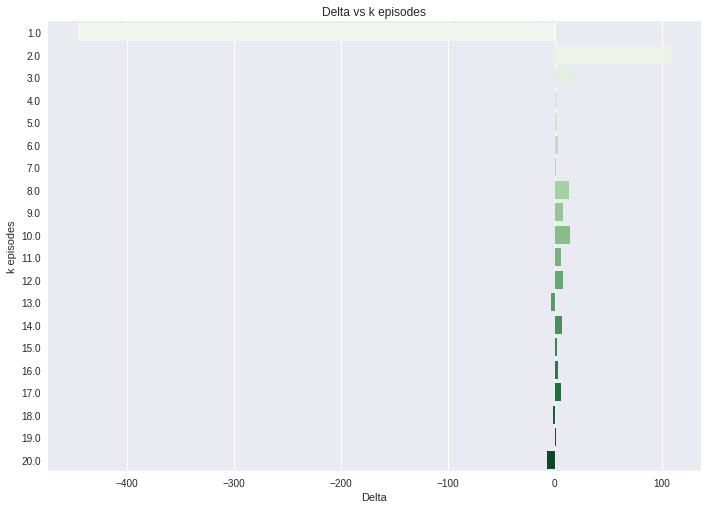

In [8]:
_ = plot_helper(x="Delta", palette="Greens", orient="h")

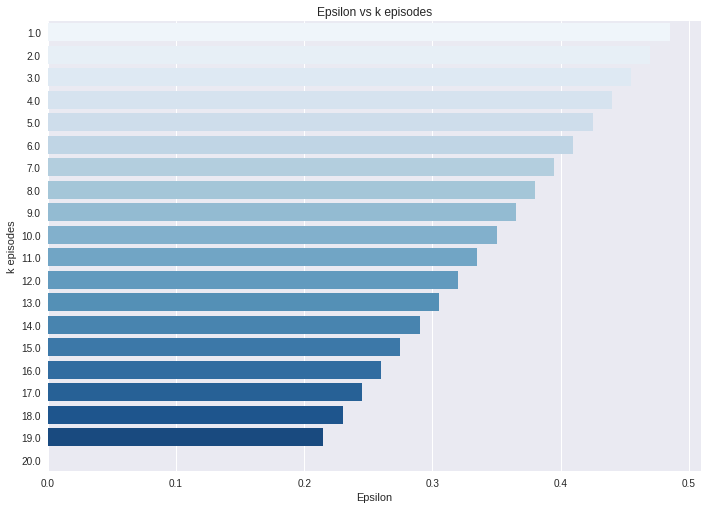

In [9]:
_ = plot_helper(x="Epsilon", palette="Blues", orient="h")